# Preparing the corpora

```




```
#### contents
- [Retreiving the files](#Retreiving-the-files)
- [Preparation](#Preparation)
- [A quick look at the data](#A-quick-look-at-the-data)
- [Training and test split](#Training-and-test-split)
- [Final notes](#Final-notes)

## Retreiving the files

- [contents](#contents)

resources available at : https://www.sadilar.org/

language   - Language codes : corpora uri

- isiNdebele - nr  : https://repo.sadilar.org/handle/20.500.12185/308
- isiXhosa   - xh  : https://repo.sadilar.org/handle/20.500.12185/314
- isiZulu    - zu  : https://repo.sadilar.org/handle/20.500.12185/321
- sePedi     - nso : https://repo.sadilar.org/handle/20.500.12185/330
- seSotho    - st  : https://repo.sadilar.org/handle/20.500.12185/336
- seTswana   - tn  : https://repo.sadilar.org/handle/20.500.12185/343
- siSwati    - ss  : https://repo.sadilar.org/handle/20.500.12185/348
- tshiVenda  - ve  : https://repo.sadilar.org/handle/20.500.12185/357
- xiTsonga   - ts  : https://repo.sadilar.org/handle/20.500.12185/364
- Afikaans   - af  : https://repo.sadilar.org/handle/20.500.12185/293
- English    - en  : https://repo.sadilar.org/handle/20.500.12185/301

Download each file in turn and put it in the data folder and corpora subfolder.

In [54]:
import os
import sys
import json
import pickle
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

In [3]:
DATA_PATH = '../data'
MODULES_PATH = '../modules'

sys.path.append(MODULES_PATH)

In [59]:
from data import raise_one_level, prepare_training_data

## Preparation

- [contents](#contents)

We start by pulling out the langauage codes from the files.

In [5]:
file_listing = os.listdir(os.path.join(DATA_PATH,'corpora'))

language_codes = [i.replace("corpora.nchlt.","").replace(".zip","") for i in file_listing]
language_codes

['af', 'en', 'nr', 'nso', 'ss', 'st', 'tn', 'ts', 've', 'xh', 'zu']

Then we read each file in turn and track the file title, the body of the text and the class.

In [6]:
prepped_documents = []

for idx, zipped in enumerate(file_listing):
    if language_codes[idx] == 'en':
        zfilename = '{}/1.Corpus/CORP.NCHLT.{}.CLEAN.1.0.0.txt'.format(language_codes[idx],"{}")
    else:
        zfilename = '{}/2.Corpora/CORP.NCHLT.{}.CLEAN.2.0.txt'.format(language_codes[idx],"{}")
    
    
    with zipfile.ZipFile('../data/corpora/{}'.format(zipped)) as z:
        language_codes[idx] if True else 'no'
        code = 'eng' if language_codes[idx] == 'en' else language_codes[idx]
        
        with z.open(zfilename.format(code)) as f:
            lines = f.readlines()

    text = "".join([str(i) for i in lines[::11]])
    documents = text.replace("\\n","").split("<fn>")
    
    for document in documents:
        document_split = document.split("</fn>")
        if len(document_split) > 1:
            title, body = document_split
            prepped_documents.append({'title': title, 'body': body, 'class': language_codes[idx]})

## A quick look at the data

- [contents](#contents)

We convert the data to a dataframe for easy analysis. We have 1650 documents. We would like to have a look at the class distribution in terms of 

- documents
- sentences
- word
- characters

Ultimately we would like enough data to be able to train a reasonably good model but not too much data so we have memory problems.

In [8]:
documents_df = pd.DataFrame(prepped_documents)
documents_df.shape

(1650, 3)

We check the data to make sure its correctly formatted.

In [9]:
documents_df.head()

,body,class,title
0,"\r'b""Werkende aansoekers: Dui asseblief jou ba...",af,(1124200875659 AM) GEMS_APP(AFRIKAANS).txt
1,\r'b'Uitstekende gesondheidsorgvoordele teen b...,af,(3102010124331 PM) FINAL MB AFRIKAANS.txt
2,\r'b'Uitstekende gesondheidsorgvoordele teen b...,af,(3172010120044 PM) FINAL MB AFRIKAANS.txt
3,\r'b'Om alle staatsdienswerknemers van gelyke ...,af,(32201090225 AM) REO Afrikaans met benefit sch...
4,"\r'b""Sou u na 1 Januarie van 'n jaar aansluit,...",af,(42200942018 PM) NIMAS_Appli. FormAfr_PD7023.txt


The document counts are over weight for Afrikaans, English and Xhosa. These languages are quite common in the Cape, that seems curious. 

In [10]:
# document counts

documents_df['class'].value_counts()

af     436
en     355
xh     240
st      98
nr      93
tn      90
zu      81
nso     72
ss      69
ve      63
ts      53
Name: class, dtype: int64

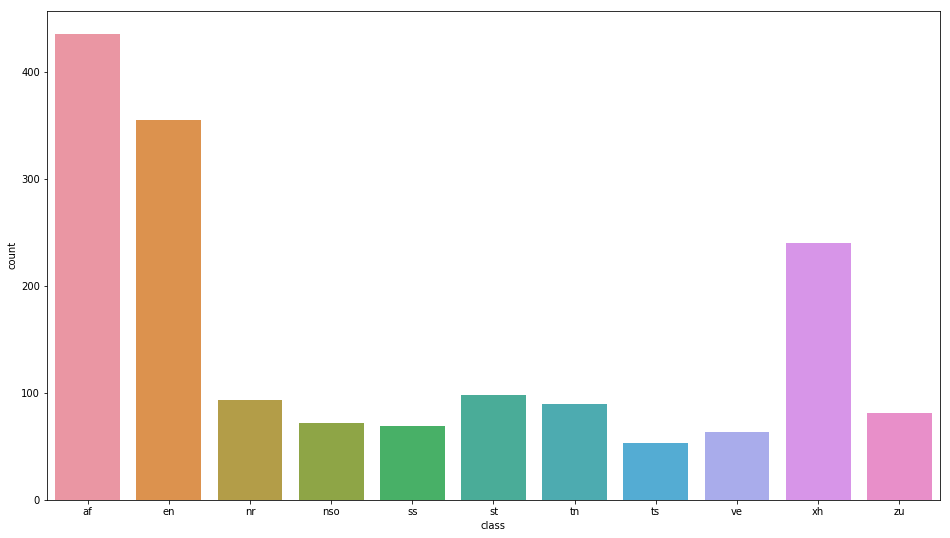

In [17]:
plt.figure(figsize=(16,9))
ax = sns.countplot(x="class", data=documents_df)

The sentence counts are a little different. They are well balanced, at roughly `3000` each with Venda under weight around `2053` and English over weight at `9736`. 

In [38]:
# sentence counts - beautifully balanced

sentence_counts = documents_df['body'].apply(lambda x: len(x.split(". "))).dot(pd.get_dummies(documents_df['class'])) 
sentence_counts

af     4645
en     9736
nr     2520
nso    3591
ss     3148
st     3189
tn     2394
ts     2635
ve     2053
xh     3274
zu     3371
Name: body, dtype: int64

In [20]:
sentence_counts.index

Index(['af', 'en', 'nr', 'nso', 'ss', 'st', 'tn', 'ts', 've', 'xh', 'zu'], dtype='object')

<BarContainer object of 11 artists>

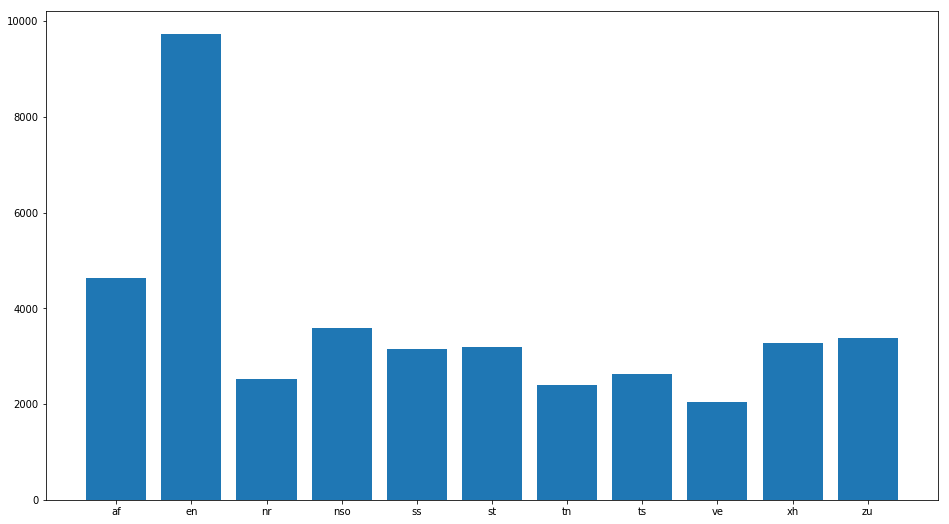

In [21]:
plt.figure(figsize=(16,9))
plt.bar(sentence_counts.index, sentence_counts)

The sentence distributions look good but they are not immediately accessible. They are reformatted here. First they are extraced a separate object called `sentences`. Second there is a string `'\\r\'b\'` which needs to be stripped form the first sentence of each document. Finally the sentences are put in an unested list, where each document is a dictionary with classes body and class, representing the text and classs respectively.

In [23]:
sentences = documents_df.apply(lambda x: [{'class': x['class'], 'body': b} for b in x['body'].split(". ")], 
                              axis=1).values.tolist()

In [24]:
doc_ids = documents_df['class'].value_counts().cumsum()

In [25]:
sentences[0][0], sentences[doc_ids[1]][0], sentences[doc_ids[2]][0], sentences[doc_ids[10]-1][0]

({'class': 'af',
  'body': '\\r\'b"Werkende aansoekers: Dui asseblief jou basiese maandelikse salaris aan'},
 {'class': 'nr',
  'body': "\\r'b'Nangabe iye, ingabe ulilunga eliyihloko namkha ungowondliwako?\\r'b'Ngiyezwisisa kobana imininingwana yami emayelana nezamaphilo ayizokusetjenziselwa iinhloso ezimayela nerhwebo namkha ithengiswe ngehloso yokwenza imali.\\r'b'Ngiyamukela kobana isiKimu/abasebenzeli baso bazakubhadela izibizo ezibonakala ziliqiniso begodu ngokuya ngemithetho yesiKimu.\\r'b'Amaforomo i-M2 ne-Z583, nangabe urhola ipentjheni begodu/namkha gade usebenza kurhulumende ngaphambilini.\\r'b'Tjheja: Nangabe isibongo somntwana siyahluka nesitatimende selunga esiqinisa isibopho emntwaneni besinikele nonobangela womehluko loyo siyafuneka.\\r'b'Sibawa wenze ukukhetha kwakho ngokutjheja, Njengoba angeze wakghona ukutjhugulula ukukhetha kwakho phakathi nonyaka ngaphandle kwakobana lokho kudluliswe yiBhodo yokweLusa iimali.\\r'b'UmThetho uthi wena namkha obondlako angeze natlolis

In [26]:
sum([len(i) for i in sentences])

40556

In [29]:
for idx, i in enumerate(sentences):
    for jdx, j in enumerate(i):
        sentences[idx][jdx]['body'] = j['body'].replace("""\\r\'b\"""","")

flat_sentences = raise_one_level(sentences)
len(flat_sentences)

40556

In [30]:
flat_sentences[0]['body']

'Werkende aansoekers: Dui asseblief jou basiese maandelikse salaris aan'

In [31]:
pd.DataFrame(flat_sentences).head()

,body,class
0,Werkende aansoekers: Dui asseblief jou basiese...,af
1,"As jy op middel- of senior bestuursvlak is, du...",af
2,sluit jongste salarisstrokie of aanstellingsbr...,af
3,Ek verstaan dat indien daar enige verswyging o...,af
4,"As jy 'n staatsamptenaar is, verskyn jou organ...",af


In [42]:
with open(os.path.join(DATA_PATH, 'sentences.json'),'w') as datafile:
    json.dump(flat_sentences, datafile)

The word counts vary around 100,000 with English around 500,000.

In [33]:
# word counts

word_counts = documents_df['body'].apply(lambda x: len(x.split())).dot(pd.get_dummies(documents_df['class'])) 
word_counts

af     194856
en     487449
nr      67973
nso    187641
ss      69755
st     159820
tn     110827
ts     115381
ve      86720
xh      98303
zu     128647
Name: body, dtype: int64

<BarContainer object of 11 artists>

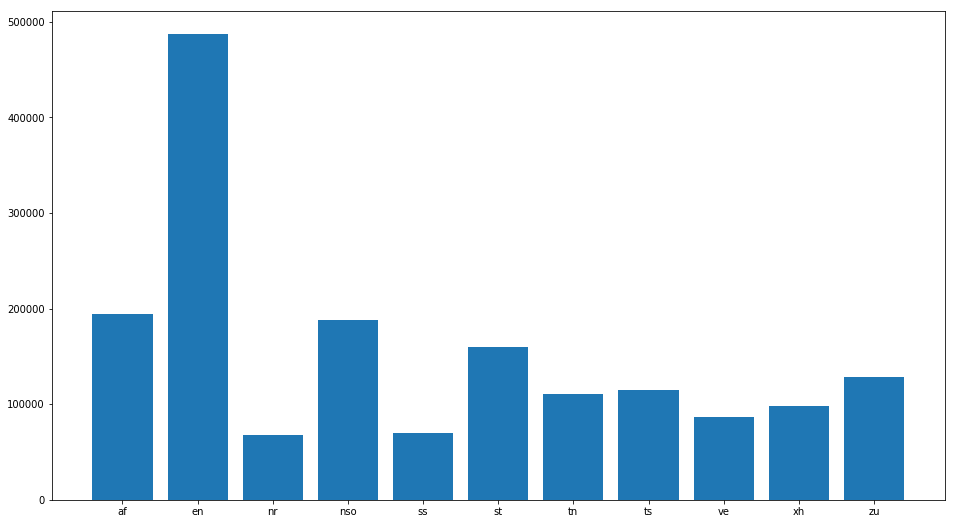

In [34]:
plt.figure(figsize=(16,9))
plt.bar(word_counts.index, word_counts)

English continues to be quite over weight at 3,000,000 characters relative to the other datasets at around 700,000.

In [36]:
# character counts - beautifully balanced

character_counts = documents_df['body'].apply(lambda x: len(list(x))).dot(pd.get_dummies(documents_df['class'])) 
character_counts

af     1333795
en     3178123
nr      693335
nso    1277737
ss      698910
st      922541
tn      652337
ts      715758
ve      589877
xh      953090
zu     1278794
Name: body, dtype: int64

<BarContainer object of 11 artists>

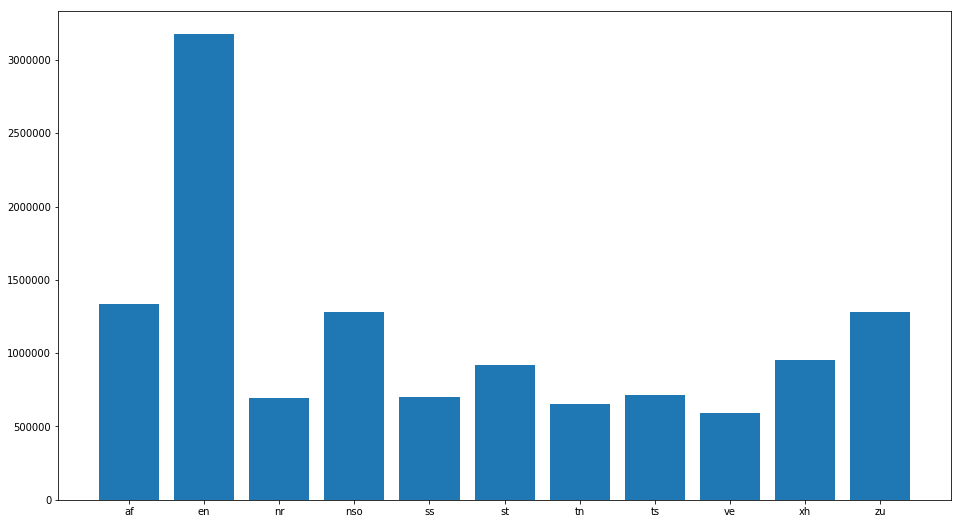

In [37]:
plt.figure(figsize=(16,9))
plt.bar(character_counts.index, character_counts)

## Training and test split

- [contents](#contents)

In [44]:
flat_sentences_df = pd.DataFrame(flat_sentences)

flat_corpora, flat_labels = flat_sentences_df['body'], flat_sentences_df['class']

In [46]:
flat_corpora.shape, flat_labels.shape

((40556,), (40556,))

In [50]:
corpora_train, corpora_test, labels_train, labels_test = train_test_split(
                                                        flat_corpora,
                                                        flat_labels,
                                                        test_size=0.25,
                                                        random_state=123)

In [51]:
corpora_train.shape, corpora_test.shape

((30417,), (10139,))

In [55]:
with open(os.path.join(DATA_PATH, 'train_data.pickle'),'wb') as datafile:
        pickle.dump((corpora_train, labels_train), datafile)

In [56]:
with open(os.path.join(DATA_PATH, 'test_data.pickle'),'wb') as datafile:
        pickle.dump((corpora_test, labels_test), datafile)

In [60]:
document_matrix, labels, pipeline_instance = prepare_training_data(corpora_train, labels_train)

In [61]:
document_matrix.shape, labels.shape, pipeline_instance

((30417, 2692), (30417, 11), Pipeline(memory=None,
      steps=[('vect', CountVectorizer(analyzer='char', binary=False, decode_error='strict',
         dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
         lowercase=True, max_df=1.0, max_features=None, min_df=1,
         ngram_range=(2, 2), preprocessor=None, stop_words=None,
         strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
         tokenizer=None, vocabulary=None)), ('tfidf', TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True))]))

In [62]:
with open(os.path.join(DATA_PATH, 'pipeline_instance.pickle'),'wb') as datafile:
        pickle.dump(pipeline_instance, datafile)

## Final notes

- [contents](#contents)